# **Statistics lecture 2 Hands-on session : solutions notebook**

This is the companion notebook to lecture 2 in the statistical course series, covering the following topics:
1. Maximum likelihood basics
2. Maximum likelihood for binned data
3. Maximum likelihood properties
4. Hypothesis testing basics

First perform the usual imports:

In [1]:
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt

## 1.  Maximum likelihood basics

Maximum likelihood is a powerful tool to *estimate* (=compute the value, in stats parlance) of unknown parameters. The principle is as follows: what we know is
* The form of the PDF $P(x,\theta)$, in terms of a random variable $x$ (the observable) and one or more unknown parameters $\theta$.
* A dataset, i.e. an observed value for the random variable
The natural usage of the PDF is to draw values of $x$, for a given value of $\theta$. What we need here is the reverse: we have the observed $x_{\text{obs}}$, and we'd like to use it to infer the value $\theta$.
Maximum likelihood (ML) says that this can be done by maximizing the PDF, considered as a function of the $\theta$ and with the random variable fixed to its observed value. This presentation of the PDF is called the *likelihood*, and it's really still just the PDF:
$$
L(\theta) = P(x_{\text{obs}}; \theta)
$$
The ML estimator for $\theta$ is then
$$
\hat{\theta} = \text{arg max}_{\theta} \, L(\theta)
$$
the value of $\theta$ that maximizes $L$.

We start with a simple example: a counting experiment where we observe $n=5$ with an expected background of $b=3$. The PDF is Poisson, with a parameter given as $s+b$, and we'd like to estimate $s$. The ML procedure can be performed as follows:

In [2]:
n = 5
b = 3

s_values = np.arange(0, 5, 0.1) # We scan s from 0 to 5 in steps of 0.1

# ==> Compute the likelihood for each value of s and plot the results; find the value of s ("s-hat") that maximizes the likelihood

If all goes well, you should get a maximum at $\hat{s} = 2$ as one could naively expect.

Note that while the position of the maximum is meaningful, the likelihood value isn't: likelihoods only need to be defined up to a multiplicative factor since we only use likelihood ratios in measurements.

## 2. Maximum likelihood for binned data

To make things a bit more interesting, we move to the analysis of binned data. We take the same model as the one from the previous lecture

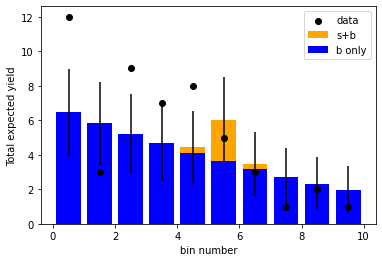

In [3]:
nbins = 10
x = np.linspace(0.5, nbins - 0.5, nbins)
# The background follows a linear shape
b_yields = np.array([ (1 - i/2/nbins) for i in range(0, nbins) ])
b_yields *= b_yields/np.sum(b_yields)
# The signal shape is a peak
s_yields = np.zeros(nbins)
s_yields[4:7] = [ 0.1, 0.8, 0.1 ]
# Now generate some data
s = 3
b = 50
s_and_b = s*s_yields + b*b_yields
b_only = b*b_yields
np.random.seed(0) # make sure we always generate the same data
data = [ np.random.poisson(s*s_yield + b*b_yield) for s_yield, b_yield in zip(s_yields, b_yields) ]
plt.bar(x, s_and_b, color='orange', yerr=np.sqrt(s_and_b), label='s+b')
plt.bar(x, b_only, color='b', label='b only')
plt.scatter(x, data, zorder=10, color='k', label='data')
plt.xlabel('bin number')
plt.ylabel('Total expected yield')
plt.legend()

The plot above shows the typical case of a binned analysis: we have 2 *templates*, i.e. reference shapes for signal and background, which are scaled by the yields $s$ and $b$. It should be obvious from the plot what the ML estimate $\hat{s}$ is going to be: this just corresponds to the "best fit" of the templates to the data.

If you're seeing the same example as on my machine, the content of bin 5 indicates something like $s = 2$, a positive signal but a bit smaller than the $s=3$ value for which we made the plot. Of course $s$ could also be negative, for instance if bin 5 was well below the background in this bin.

We now check this by performing the ML estimation. A small change compared to the previous case is that instead of $L(s)$, we'll be using the quantity $\lambda = -2 \log L(s)$. The reason is as follows: first, the total PDF for all the bins together is a product of Poisson terms, one for each bin:
$$
L(s) = \prod_{i=1}^{n_{\text{bins}}} P(n_i, s f_{s,i} + b f_{b,i})
$$
Technically it's easier to deal with sums than products, and the log does this for us. As we'll see in a moment, this is also useful to deal with Gaussian PDFs, since in this case the log just extracts the squared term in the exponent. This is also the reason for the $-2$ term in the formula, since this term comes with a $-1/2$ factor.
The only consequence in practical terms is that instead of $L(s)$ we compute $\lambda(s)$, and that we now want to minimize instead of maximimizing. But the ML estimate $\hat{s}$ remains the same, since the value of $s$ that maximizes $L(s)$ also minimizes $\lambda(s)$.

The next step is to find the ML estimate (best fit) $\hat{s}$ using $\lambda(s)$.

In [4]:
s_values = np.arange(-2, 10, 0.1) # We scan s from -2 to 3 in steps of 0.1

# ==> Compute \lambda for each value of s, plot the result and find the best-fit value among the values tested;
# ==> For later convenience, you may want to define a function lambda_s(s) that returns \lambda as a function of s

If all goes well, you should find a best-fit $\hat{s}$ of about 2.3. Of course this value is a bit imprecise due to the step size of 0.1 in the scan, but we can do better:

In [5]:
from scipy.optimize import minimize_scalar
# ==> Use the minimize_scalar function to find the minimum value. The syntax is minimize_scalar(func, (min, max)).x  (the .x returns the position of the minimum)

You should find a best-fit value of about $\hat{s} = 2.33$. Note than since $L(s)$ was defined only up to a multiplicative factor, $\lambda(s)$ is defined up to an additive constant, so the value $\lambda(\hat{s})$ at the minimum isn't meaningful by itself. On the other hand, the difference between values of $\lambda(s)$ at different $s$ is meaningful, and will be used later in hypothesis testing.

## 3. Maximum-likelihood in the Gaussian case

We've seen that the Poisson distribution can often be well approximated by a Gaussian (and other distributions as well, though the Central-limit theorem). If we write the expected number of events as
$N_i = s f_{s,i} + b f_{b,i}$ then the likelihood is
$$
L(s) = \prod_{i=1}^{n_{\text{bins}}} P(n_i, N_i) \propto \prod_{i=1}^{n_{\text{bins}}} \exp\left(-\frac{1}{2} \frac{(n_i - N_i)^2}{\sigma_i^2} \right)
$$

And then the -2 log likelihood is

$$
\lambda(s) = -2 \log L(s) = \sum_{i=1}^{n_{\text{bins}}}\left(\frac{n_i - N_i}{\sigma_i}\right)^2
$$
which is of course very familiar: it's just the usual $\chi^2$. This is an important motivation for using $\lambda(s)$ : it can be defined for any likelihood, but in the Gaussian case, it reduces to the $\chi^2$. (Note that this is up to an additive constant, since the Gaussian PDF also has a multiplicative prefactor, but as discussed above the log-likelihood is anyway defined only up to an additive constant)

The upshot is that for Gaussian cases, ML is the same as $\chi^2$ minimization -- this is why we're using "ML" and "best-fit" interchangeably in this notebook. To illustrate this, we can repeat the example above in the Gaussian case, now estimating $\hat{s}$ using the $\chi^2$.

For the standard (Pearson) $\chi^2$, we take $\sigma_i^2 = N_i$ : recall that for a Poisson distribution the variance is the same as the mean, so $\sigma^2 = N$.


In [6]:
# ==> Define a function to compute the chi2 between the model and the data as a function of s
# ==> Plot the chi2(s) value and the lambda(s) values on the same plot to see if they are close to each other as expected. You will
#     need to add a vertical offset to one of the curves to get good agreeement, which one can always do as discussed above. 
# ==> Use minimize_scalar to find the value of s which minimizes the chi2, and compare to what was found for lambda(s) above.

If all goes well, you should see that the $\chi^2$ is quite close to the Poisson case above. The difference comes from the fact that the event counts are not quite large enough for the Poisson distributions to be quite Gaussian, and the residual non-Gaussianity leads to a small discrepency between the exact Poisson model and its $\chi^2$ approximation.

One can have an even less Gaussian situation by setting $s$ and $b$ to smaller values (say $s=2$ and $b=1$), so that the number of events is not large enough to trigger the Central-limit theorem. In this case one should get an asymmetric shape for the Poisson $\lambda$ and sizable differences with the $\chi^2$ approximation. 

**The rest of this section is optional -- feel free to skip if you are short on time (you should be about half way through the session at this point)**

In [7]:
# ==> (optional) Repeat the previous study for s=2 and b=1 to check for larger non-Gaussian effect.
# ==> (optional) One can also repeat it again for larger counts such as b=1000, s=20 and check that the chi2 is now an excellent approximation to the Poisson.

One can also define the alternate *Neyman* $\chi^2$, where the uncertainty is taken from the observation rather than the expectation, so $\sigma_i^2 = n_i$. This has some advantages, but typically agrees less well with the the Poisson limit:

In [8]:
# ==> Repeat the previous study (going back to the original event yields), and add the Neyman chi2 curve to the plot with lambda(s)

## 4. Hypothesis testing basics

So far we've focused on estimating parameters, but to get realistic results (including setting uncertainties on the best-fit values), we need an additional ingredient, *hypothesis testing*. The procedure for this is as follows:
* Define the hypotheses to test. We need two of them: a baseline *null* hypothesis, and an *alternate* which is tested against it
* Define the *test* to perform -- meaning the observables to use, and procedure to decide which hypothesis to accept.
* Compute the result of the test for the observed data, in particular the *p-value* of the test, and decide whether to accept the null or the alternate hypothesis.

To start with, we consider a simple Poisson counting process
* Define two different signal hypotheses ($n=0$ and $n=5$)
* Define the test in terms of the observed number of events: if it is less than some threshold, accept the null $n=0$, otherwise $n=5$.
* As for any test, there are two ways to go wrong:
   * Rejecting the null although it is true (false positive): the fraction of such cases is the Type-I error rate or p-value.
   * Accepting the null although it is false (false negative) : : the fraction of such cases is the Type-II error rate, also (1 - Power)

A more stringent test reduces the Type-I error rate, but at the expense of an increased Type-II rate and vice versa. This is illustrated by the *ROC curve* which shows the each error rate as a function of the other. The threshold for the test should be chosen depending on the desired balance between these error rates.

For the study below, we consider a counting experiment and use the observed count $n$ as the discriminant.

In [9]:
b = 10 # background of 10 events
s_null = 0 # the null hypothesis: no signal
s_alt  = 5 # the alternate hypothesis: 

ns = np.arange(1, 30, 1) # consider various observed values

# ==> Compute and plot the PDFs for the two hypotheses. These are Poisson PDFs with parameters s_null + b and s_alt + b,
#     and should be evaluated at the n values given in the array above.
#     Reminder: the poisson PDF is given by scipy.stats.poisson.pmf(n, s+b)

threshold1 = 12
threshold2 = 16

# ==> Compute the Type-I error probability (p-value) and the Type-II error probability for 2 tests: one with a threshold
#     at n = 12 and the other at n=16
#     Also optionally plot the results using the fill_between command of matplotlib, as done in lecture 1

thresholds = np.arange(1, 30, 1)
# ==> Compute the Type-I and Type-II error probabilities for each threshold in the list above, and plot the ROC curve


The threshold for discovery in physics is often set at $5\sigma$, which corresponds to a p-value of about $3 \cdot 10^{-7}$. What threshold would one use to get so small a Type-I error rate ?

In [10]:
# ==> Compute the value of the threshold on n which would give us a 5sigma discovery

You should find $n_{\text{obs}} \ge 29$. If we get such a large n, then we can indeed reject the null at with a p-value corresponding to a $5\sigma$ threshold. This is the setting for a discovery: we have rejected the no-signal hypothesis in favor of an hypothesis with non-zero signal.

However the power of the test is also very low, which means that even if the signal is really there, we are very unlikely to observe an event count of $n_{\text{obs}} \ge 29$. The reason for this is the fact that the alternate hypothesis corresponds to a relatively small event yield, on the scale of the measurement uncertainties, so it is very hard to find evidence for it.

If we choose a hypothesis with a larger signal value, say $20$ signal events, then things are easier. The threshold for discovery is still 29 events (the p-value only depends on the null, not the alternative), but now the power is much larger

In [11]:
s2 = 20
# ==> Compute the power of the test 

You should find that the power is about 50% -- i.e. and approximately 50% chance of discovery if there is indeed a signal of this size present.